# **Clustering the Data**

## Objectives

* We will investigate the data using clustering algoritthms to investigate our hypothesis # something

## Inputs

* The game data from before the train test split at the beginning of notebook 04. 

## Outputs

* A clustering model and some analysis of the underlying dataset.

## Additional Comments
* This notebook follow the analysis done in notebook 07 of the Churnometer walkthrough project.

---

# Change working directory
We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os

home_dir = '/workspace/pp5-ml-dashboard'
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our prepared data.

In [3]:
import pandas as pd
from src.utils import get_df, save_df

game_data = get_df('game_pre_split', 'datasets/clean/csv')


## Section 1: Set up problem
The game of basketball as evolved over the years. For example, we saw in our exploratory data analysis that there was a correlation between 3 pointers and year. We are going to test if clustering will detect the various eras of basketball, or perhaps it will define new ones.

We will then look at the profiles of each cluster to see how it groups games of basketball and try to determine if these clusters have any correlation with time.



In [4]:
game_data.drop(labels=['season'],inplace=True,axis=1)
game_data.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,29,40,21,11,7,17,19,100,0,0
28500006,39,88,0,2,26,41,20,28,48,17,...,31,42,19,7,7,18,32,108,0,0
28500010,39,88,0,1,40,49,17,40,57,23,...,28,41,27,10,7,20,32,116,1,0
28500011,42,82,0,2,24,38,10,24,34,30,...,30,47,23,10,7,19,28,112,0,0
28500008,36,91,0,4,33,52,18,29,47,17,...,31,44,26,11,3,22,40,119,0,0


Now we construct our pipeline for clustering. The format for the pipeline was inspired by the clustering pipeline in the Churnometer walkthrough project.

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from feature_engine import transformation as vt

TRANSFORM_ASSIGNMENT = {
    'yeo_johnson': ['dreb_away', 'blk_home', 'oreb_away', 'fta_away',
                    'dreb_home', 'ast_home', 'stl_away', 'pts_away',
                    'stl_home', 'reb_away', 'pts_home', 'fgm_away',
                    'oreb_home', 'pf_away', 'pf_home'],
    'box_cox': ['ast_away', 'fta_home']
    }
TRANSFORMS = {'box_cox':(vt.BoxCoxTransformer,False),
              'yeo_johnson':(vt.YeoJohnsonTransformer,False)}

def pipe_v1(thresh=0.7,p_components=50,clusters=50):
    pipe = Pipeline([
        ("corr_selector", SmartCorrelatedSelection(method="pearson",
                                                   threshold=thresh, 
                                                   selection_method="variance"))])
    pipe.fit(game_data)
    dropping = pipe['corr_selector'].features_to_drop_
    new_assignments = { key: [val for val in value if val not in dropping] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipe.steps.append(
            (transform, TRANSFORMS[transform][0](variables=targets))
            )
    pipe.steps.append(('scaler', StandardScaler()))
    pipe.steps.append(("PCA", PCA(n_components=p_components, random_state=42)))
    pipe.steps.append(("model", KMeans(n_clusters=clusters, random_state=42)))
    return pipe



We will end up tuning the number of clusters and components as hyperparameters. It will be interesting to luck at how the analysis changes as we move between the number of clusters. At each stage, we will see how the function that assigns each game to its season behaves on clusters.

## Section 2: PCA
We start by doing some Principal component analysis.

In [6]:
# to suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logging.captureWarnings(True)
os.environ['PYTHONWARNINGS']='ignore'

pipe = pipe_v1()
pca_pipe = Pipeline(pipe.steps[:-2])
game_data_pca = pca_pipe.fit_transform(game_data)


We are now going to analyze the principal components. Feel free to adjust the number of components.

* The 15 components explain 97.89% of the data 



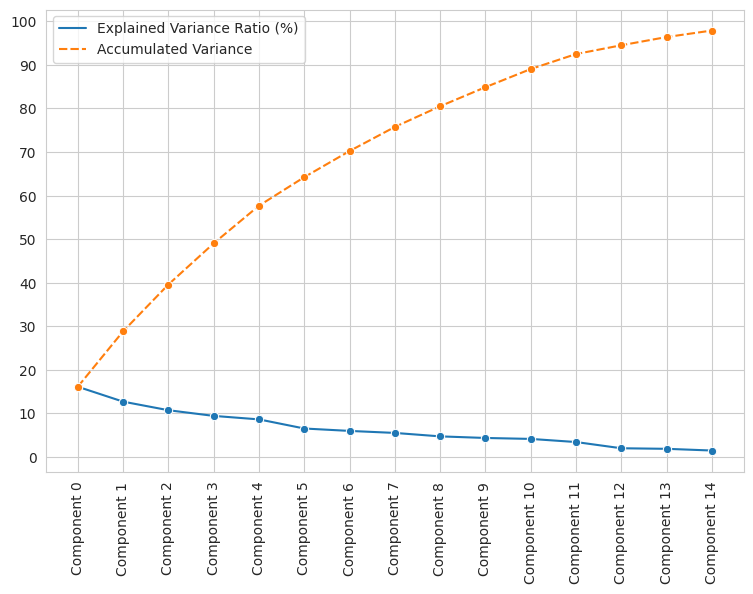

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# This function is from the notebook 07 of the 
# Churnometer walkthrough project.
def pca_component_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)

    ComponentsList = [f"Component {number}"
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )
    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )
    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_component_analysis(game_data_pca, 15)


As we are hoping the data will be grouped into eras, each of which is multiple years long. We expect there to be a fair number of clusters, so we don't mind having many components.

* The 9 components explain 80.51% of the data 



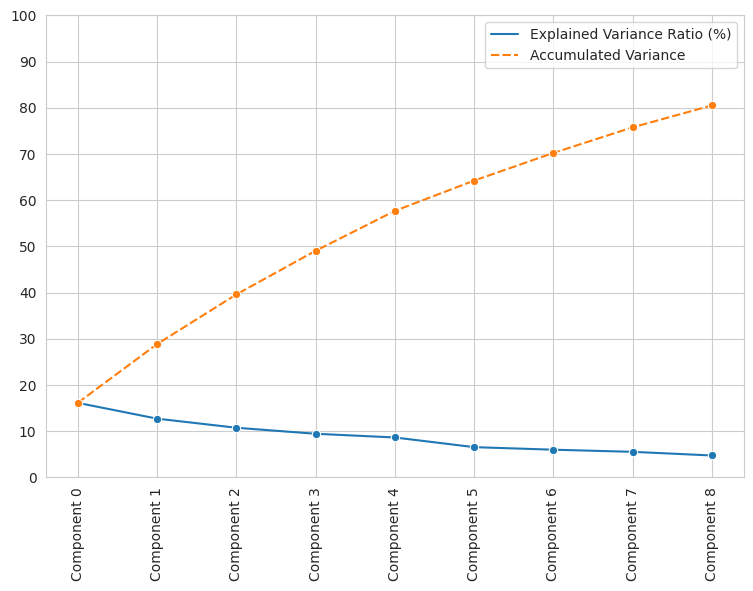

In [8]:
pca_component_analysis(game_data_pca,9)


So we redefine our pipeline creation function to have 9 as the number of components.

In [9]:
def pipe_v2(thresh=0.7,clusters=50):
    pipe = pipe_v1(thresh=thresh,p_components=9,clusters=clusters)
    return pipe

Now we need to use the elbow method and look at silhouette scores.

## Section 3: Elbow Method and Silhouette scores
These will help us determine the appropriate number of clusters to use for our algorithm. We are also taking into account some domain knowledge, which is that eras in basketball range from 6 to 10 years. It is not a well defined concept so we don't have a hard number. Our dataset ranges from 1985 until 2022. So we (conservatively) expect there to be between 4 and 7 eras.

In [10]:
new_pipe = pipe_v2()
pca_part_of_pipe = Pipeline(new_pipe.steps[:-1])
game_data_pca = pca_part_of_pipe.fit_transform(game_data)

In [11]:
'''from yellowbrick.cluster import KElbowVisualizer


# This is from notebook 07 of the 
# Churnometer walkthrough project.
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1,11))
visualizer.fit(game_data_pca) 
visualizer.show() 
plt.show()
'''

'from yellowbrick.cluster import KElbowVisualizer\n\n# This is from notebook 07 of the \n# Churnometer walkthrough project.\nvisualizer = KElbowVisualizer(KMeans(random_state=42), k=(1,11))\nvisualizer.fit(game_data_pca) \nvisualizer.show() \nplt.show()\n'

They are suggesting 4 clusters, but 6 also looks promising. Let's see how the Silhouette scores behave with respect to these different numbers of clusters.

In [12]:
'''from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start = 3
n_cluster_stop = 8

# This is from the notebook 07 of the 
# Churnometer walkthrough project.
print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(game_data_pca)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters,
                                                       random_state=42),
                                      colors='yellowbrick')
    visualizer.fit(game_data_pca)
    visualizer.show()
    plt.show()
    print("\n")

'''

'from yellowbrick.cluster import SilhouetteVisualizer\n\nn_cluster_start = 3\nn_cluster_stop = 8\n\n# This is from the notebook 07 of the \n# Churnometer walkthrough project.\nprint("=== Average Silhouette Score for different number of clusters ===")\nvisualizer = KElbowVisualizer(KMeans(random_state=42), k=(\n    n_cluster_start, n_cluster_stop), metric=\'silhouette\')\nvisualizer.fit(game_data_pca)\nvisualizer.show()\nplt.show()\nprint("\n")\n\n\nfor n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):\n\n    print(f"=== Silhouette plot for {n_clusters} Clusters ===")\n    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters,\n                                                       random_state=42),\n                                      colors=\'yellowbrick\')\n    visualizer.fit(game_data_pca)\n    visualizer.show()\n    plt.show()\n    print("\n")\n\n'

The analysis suggest using 3 clusters. After adding the clustering data to the data frame we will see if the clustering correlates with the `season` feature.

In [13]:
pipe_w_clusters = pipe_v2(clusters=3)
game_w_clusters = game_data.copy()
game_w_clusters.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,29,40,21,11,7,17,19,100,0,0
28500006,39,88,0,2,26,41,20,28,48,17,...,31,42,19,7,7,18,32,108,0,0
28500010,39,88,0,1,40,49,17,40,57,23,...,28,41,27,10,7,20,32,116,1,0
28500011,42,82,0,2,24,38,10,24,34,30,...,30,47,23,10,7,19,28,112,0,0
28500008,36,91,0,4,33,52,18,29,47,17,...,31,44,26,11,3,22,40,119,0,0


Now we will fit both of these pipelines and see what they tell us.

In [14]:
pipe_w_clusters.fit(game_w_clusters)

Pipeline(steps=[('corr_selector',
                 SmartCorrelatedSelection(selection_method='variance',
                                          threshold=0.7)),
                ('yeo_johnson',
                 YeoJohnsonTransformer(variables=['blk_home', 'oreb_away',
                                                  'fta_away', 'ast_home',
                                                  'pts_away', 'reb_away',
                                                  'pts_home', 'oreb_home'])),
                ('box_cox',
                 BoxCoxTransformer(variables=['ast_away', 'fta_home'])),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=9, random_state=42)),
                ('model', KMeans(n_clusters=3, random_state=42))])

Let's add the clustering data to the dataframe.

In [15]:
game_w_clusters['Clusters'] = pipe_w_clusters.predict(game_data)

game_w_clusters.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off,Clusters
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,40,21,11,7,17,19,100,0,0,1
28500006,39,88,0,2,26,41,20,28,48,17,...,42,19,7,7,18,32,108,0,0,1
28500010,39,88,0,1,40,49,17,40,57,23,...,41,27,10,7,20,32,116,1,0,1
28500011,42,82,0,2,24,38,10,24,34,30,...,47,23,10,7,19,28,112,0,0,1
28500008,36,91,0,4,33,52,18,29,47,17,...,44,26,11,3,22,40,119,0,0,1


* Cluster frequencies 
   Clusters
0      0.46
1      0.29
2      0.25 




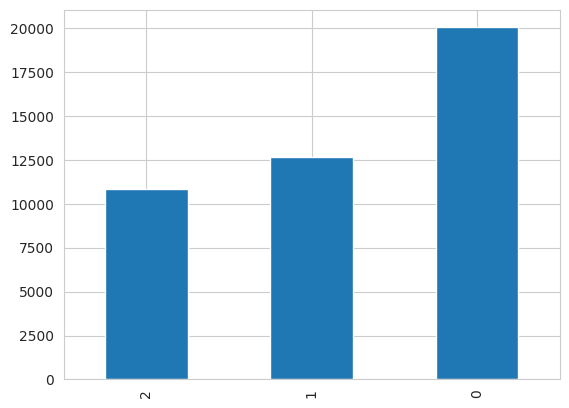

In [16]:
print(f"* Cluster frequencies \n{game_w_clusters['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
game_w_clusters['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

Let's add the season data back. We will see how the seasons are distributed across the clusters before training our classifcation model to get the profile of the individual clusters. Remember that the 1985-1986 season corresponds to 0 in the dataframe.

In [19]:
game_seasons = get_df('game_pre_split', 'datasets/clean/csv').filter(['season'])
clusters_only = game_w_clusters.filter(['Clusters'])
season_clusters = clusters_only.join(game_seasons)


          Clusters    season
Clusters  1.000000  0.351203
season    0.351203  1.000000


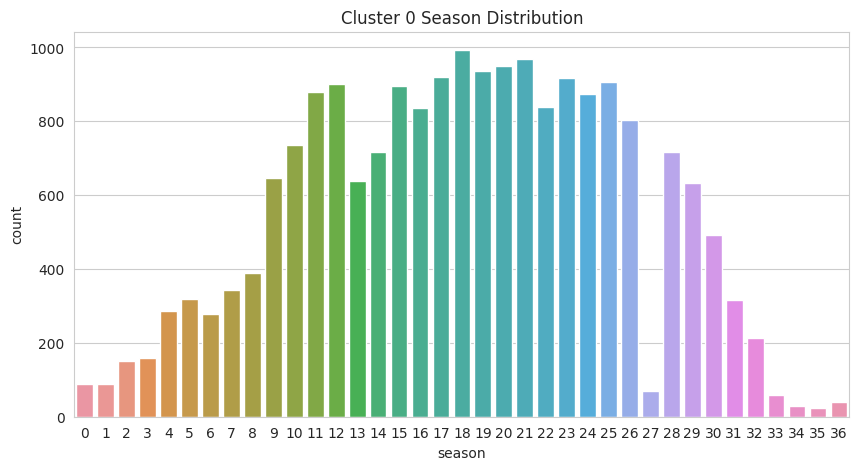

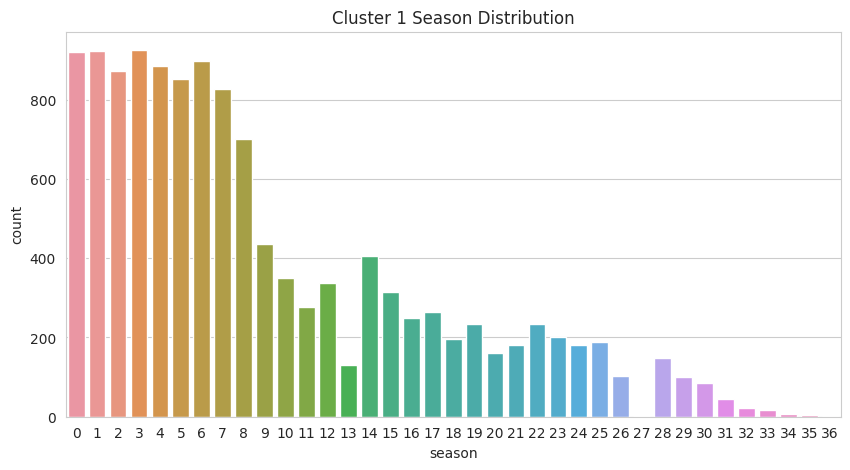

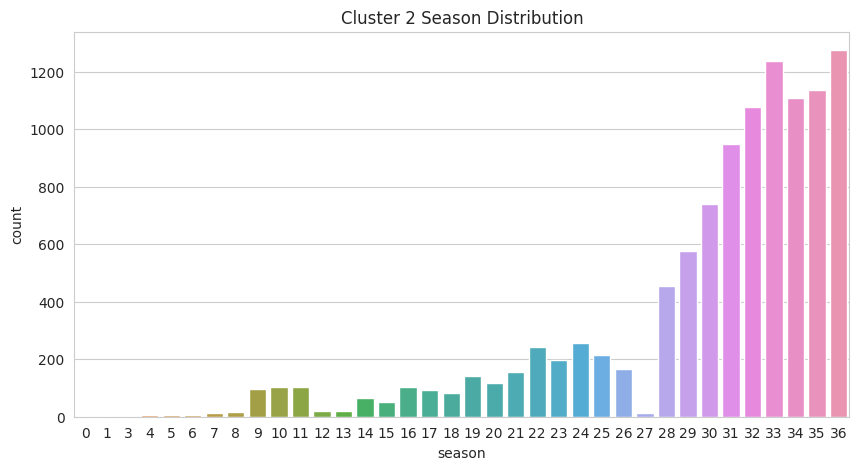

In [20]:

for i in range(3):
    cluster = season_clusters.query(f'Clusters == {i}')
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(data=cluster, x="season").set_title(f"Cluster {i} Season Distribution")
    plt.show()

So perhaps the clusters are related to time. Let's look at the other correlations with respect to the clustering.

Note: The drop in the 27th season alerted us to an anomaly in our dataset. The raw data only has records from the playoffs for that season. This is unfortunate, but such is life.

In [22]:
game_w_clusters = game_w_clusters.join(game_seasons)
clusters_correlation = game_w_clusters.corr()
print(clusters_correlation['Clusters'].sort_values(key=lambda x: abs(x), ascending=False)[:8])

ValueError: columns overlap but no suffix specified: Index(['season'], dtype='object')

Note that season is not among the most highly correlated features.
We will look at the correlation coefficients again when we attempt to classify the clusters using an adaptive boost model.

Let's investigate how the clusters and the components from the PCA relate to one another.

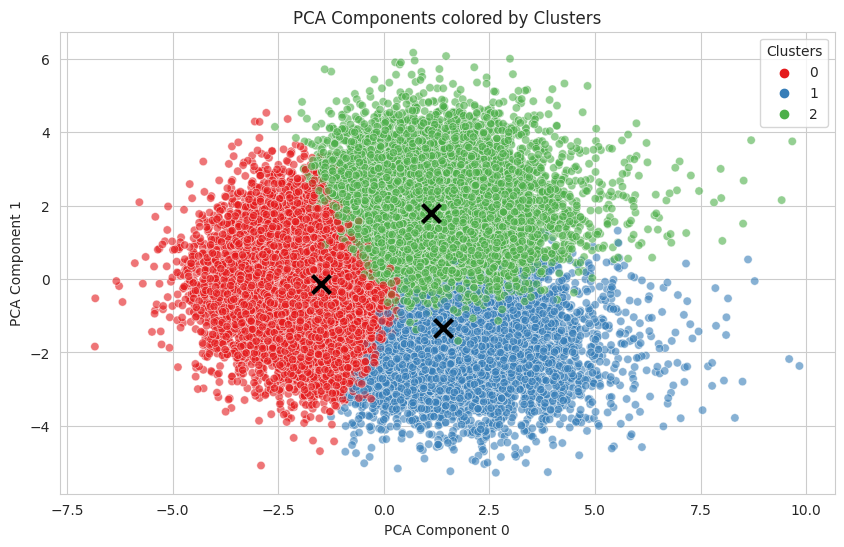

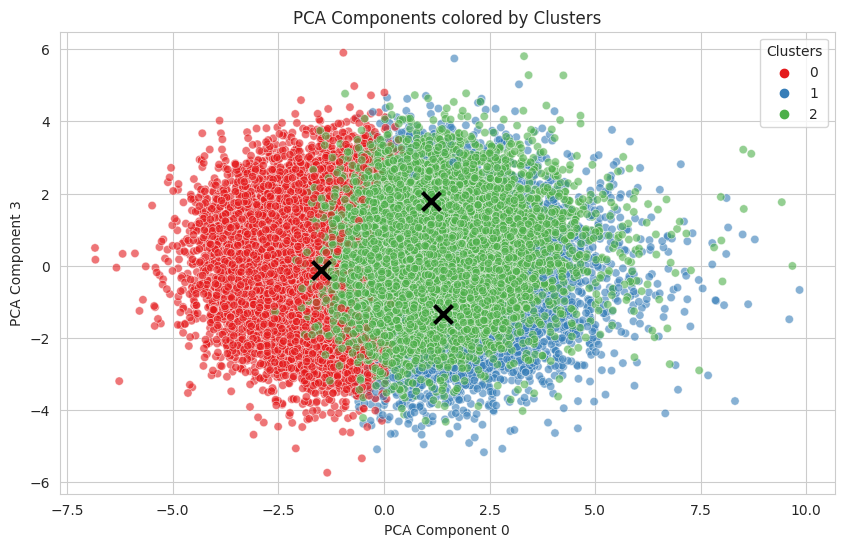

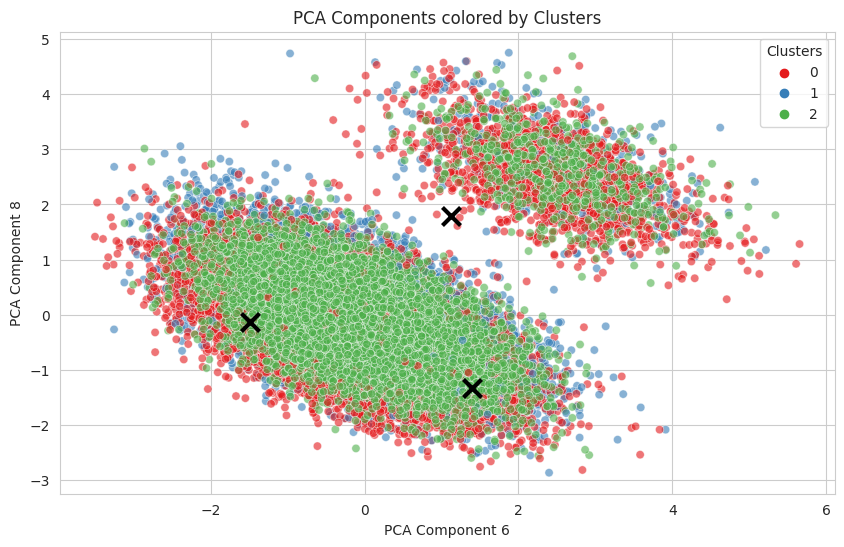

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")


def compare_components_w_clusters(a:int,b:int,pca_step,cluster_step,pipe):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_step[:, a], y=pca_step[:, b],
                hue=cluster_step['Clusters'], palette='Set1', alpha=0.6)
    plt.scatter(x=pipe['model'].cluster_centers_[:, 0],
            y=pipe['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
    plt.xlabel(f"PCA Component {a}")
    plt.ylabel(f"PCA Component {b}")
    plt.title("PCA Components colored by Clusters")
    plt.show()

interesting_pairs = [(0,1), (0,3), (6,8)]
for a,b in interesting_pairs:
    compare_components_w_clusters(a, b, game_data_pca, game_w_clusters,
                                  pipe_w_clusters)


Feel free to look at how other components compare with respect to the clusters. We felt these three were the most interesting.

## Section 4: Cluster Profile
We next wish to determine the profile of these clusters. We do this by training a classification model on the data (with season added back in) with the clusters as the target. The important features of the models will help us to determine the profiles of the individual clusters.

In our model selection notebook, we found that AdaBoost and Logistic Regression were good models for working with this data. We will use AdaBoost as it works on multi-class classification problems without any need for adjustment.

In [43]:
from sklearn.model_selection import train_test_split


df = game_w_clusters.copy()
X_train, X_test, y_train, y_test = train_test_split(
                    df.drop(['Clusters'], axis=1),
                    df['Clusters'], test_size=0.2,
                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(34876, 34)
(8719, 34)
Index(['fgm_home', 'fga_home', 'fg3m_home', 'fg3a_home', 'ftm_home',
       'fta_home', 'oreb_home', 'dreb_home', 'reb_home', 'ast_home',
       'stl_home', 'blk_home', 'tov_home', 'pf_home', 'pts_home',
       'plus_minus_home', 'fgm_away', 'fga_away', 'fg3m_away', 'fg3a_away',
       'ftm_away', 'fta_away', 'oreb_away', 'dreb_away', 'reb_away',
       'ast_away', 'stl_away', 'blk_away', 'tov_away', 'pf_away', 'pts_away',
       'home_wins', 'play_off', 'Clusters', 'season'],
      dtype='object')


Now we create our classifier pipeline. We will try it with the default parameters as well as the parameters we found in the last notebook.

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel


def clf_pipe(thresh=0.7, params={}):
    pipe = Pipeline([
        ('corr_selector',
         SmartCorrelatedSelection(method="pearson",
                                  threshold=thresh,
                                  selection_method="variance"))
                        ])
    pipe.fit(X_train)
    dropping = pipe['corr_selector'].features_to_drop_
    new_assignments = { key: [val for val in value if val not in dropping] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipe.steps.append(
            (transform, TRANSFORMS[transform][0](variables=targets))
            )
    pipe.steps.append(('scaler', StandardScaler()))
    model = AdaBoostClassifier(random_state=42,**params)
    pipe.steps.append(("feat_selection", SelectFromModel(model)))
    pipe.steps.append(('model',model))
    return pipe

ada_thresh = 0.8
ada_params = {'n_estimators': 110, 'learning_rate': 1.133,
              'algorithm': 'SAMME.R'}

In [27]:
default_ada_pipe = clf_pipe()
default_ada_pipe.fit(X_train, y_train)

tuned_ada_pipe = clf_pipe(thresh=ada_thresh, params=ada_params)
tuned_ada_pipe.fit(X_train, y_train)

Pipeline(steps=[('corr_selector',
                 SmartCorrelatedSelection(selection_method='variance')),
                ('yeo_johnson',
                 YeoJohnsonTransformer(variables=['dreb_away', 'blk_home',
                                                  'oreb_away', 'fta_away',
                                                  'dreb_home', 'ast_home',
                                                  'stl_away', 'pts_away',
                                                  'stl_home', 'reb_away',
                                                  'pts_home', 'oreb_home',
                                                  'pf_away'])),
                ('box_cox',
                 BoxCoxTransformer(variables=['ast_away', 'fta_home'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(learning_rate=1.133,
                                                              n_estimators=110,
    

In [29]:
from sklearn.metrics import classification_report


print("Default AdaBoost:")
d_predicted_train = default_ada_pipe.predict(X_train)
d_predicted_test = default_ada_pipe.predict(X_test)
print("### Train Set ##")
print(classification_report(y_train,d_predicted_train))
print("\n### Test Set ###")
print(classification_report(y_test,d_predicted_test))
print("="*30)
print("="*30)
print("Tuned AdaBoost:")
t_predicted_train = tuned_ada_pipe.predict(X_train)
t_predicted_test = tuned_ada_pipe.predict(X_test)
print("### Train Set ###")
print(classification_report(y_train,t_predicted_train))
print("### Test Set ###")
print(classification_report(y_test,t_predicted_test))


Default AdaBoost:
### Train Set ##
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     16090
           1       0.91      0.86      0.88     10137
           2       0.91      0.92      0.92      8649

    accuracy                           0.91     34876
   macro avg       0.91      0.91      0.91     34876
weighted avg       0.91      0.91      0.91     34876


### Test Set ###
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3969
           1       0.92      0.86      0.89      2549
           2       0.92      0.91      0.91      2201

    accuracy                           0.91      8719
   macro avg       0.91      0.91      0.91      8719
weighted avg       0.91      0.91      0.91      8719

Tuned AdaBoost:
### Train Set ###
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     16090
           1       0.95      0.92      0.9

The performance of the models is similar on the training and test sets, so they are generalizing well. Both classifiers are good, but the one with the hyperparameters from the last notebook performs better. Let's look at what the important features are.

          fgm_home  fga_home  fg3m_home  fg3a_home  ftm_home  fta_home  \
game_id                                                                  
21900303        50       106         13         30        22        32   
28800893        43        92          0          4        35        41   
28800204        40        82          1          7        21        27   
20501038        43        72          3          6        19        25   
29800221        28        84          1          9        21        33   

          oreb_home  dreb_home  reb_home  ast_home  ...  reb_away  ast_away  \
game_id                                             ...                       
21900303         12         44        56        35  ...        60        22   
28800893         16         34        50        30  ...        31        35   
28800204         11         31        42        30  ...        40        21   
20501038         10         27        37        23  ...        41        19   
2980022

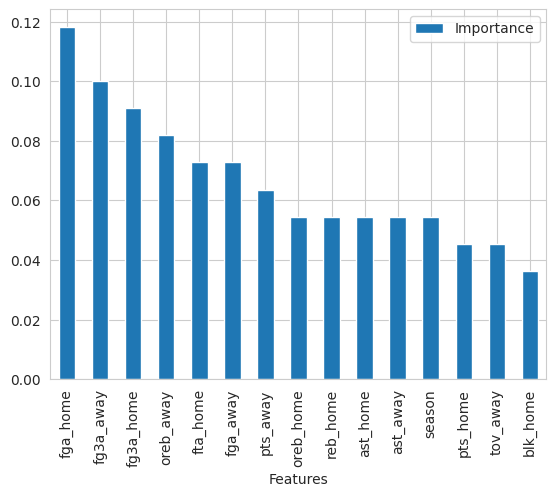

In [32]:
from src.notebook_functions import feature_importance_tree_based_models, find_features

kept, dropped = find_features(X_train, tuned_ada_pipe, initial_drop=[])
print(f"The following features were dropped: \n{dropped}")
print()
columns = X_train.filter(kept).columns
ada_model = tuned_ada_pipe['model']
feature_importance_tree_based_models(model=ada_model, columns=columns)
best_features = kept

It is interesting that attempted 3 points is so important to the clustering model. `season` has the fourth lowest importance among all features that the model used. We will use the following functions to determine the profile of the clusters. They are all from the Chrunometer walkthrough project.

In [33]:
# All functions are from notebook 07 of the Churnometer walkthrough
def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = DescriptionAllClusters.append(
            ClusterDescription)

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):
    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:
        try:  # eventually a given cluster will have only missing data for a given variable
            if EDA_Cluster[col].dtypes in ['float', 'int']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.iloc[4, 0], decimal_points)
                Q3 = round(DescStats.iloc[6, 0], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description
            else:
                raise ValueError(f"Wrong data type for {col}: {EDA_Cluster[col].dtypes}.")
        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")
    ClustersDescription['Cluster'] = str(cluster)
    return ClustersDescription


import plotly.express as px


def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.value_counts(["Clusters", target]).reset_index()
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='jupyterlab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .groupby(level=0)
                   .apply(lambda x:  100*x / x.sum())
                   .reset_index()
                   .sort_values(by=['Clusters'])
                   )
    df_relative.columns = ['Clusters', target, 'Relative Percentage (%)']

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='jupyterlab')


In [35]:
df_cluster_profile = df.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)

pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df_cluster_profile, decimal_points=0)
clusters_profile

,fga_home,fg3a_home,fta_home,oreb_home,reb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,oreb_away,ast_away,tov_away,pts_away,season
Cluster,,,,,,,,,,,,,,,
0,74.0 -- 83.0,11.0 -- 19.0,19.0 -- 30.0,9.0 -- 14.0,37.0 -- 45.0,18.0 -- 25.0,3.0 -- 6.0,89.0 -- 102.0,74.0 -- 82.0,11.0 -- 19.0,8.0 -- 13.0,17.0 -- 23.0,12.0 -- 18.0,86.0 -- 100.0,12.0 -- 24.0
1,83.0 -- 93.0,5.0 -- 15.0,24.0 -- 35.0,12.0 -- 18.0,42.0 -- 51.0,23.0 -- 30.0,4.0 -- 8.0,103.0 -- 118.0,83.0 -- 93.0,5.0 -- 15.0,11.0 -- 17.0,20.0 -- 27.0,13.0 -- 19.0,97.0 -- 112.0,3.0 -- 14.0
2,83.0 -- 92.0,23.0 -- 35.0,18.0 -- 28.0,8.0 -- 13.0,40.0 -- 49.0,21.0 -- 28.0,3.0 -- 6.0,102.0 -- 118.0,83.0 -- 92.0,24.0 -- 35.0,8.0 -- 13.0,21.0 -- 27.0,11.0 -- 16.0,101.0 -- 116.0,28.0 -- 34.0


There are many relevant features for the profiles of these clusters. We will drop all non-important features and refit the clustering and classification pipelines. Then we will look at this breakdown again and graph the distributions of these features with respect to the clusters.

## Refit Clustering
We now refit the clustering pipeline with the most relevant features determined by the profile in the last section. This will lead to a more focused model since it is only being trained on the features already determined to be most relevant to the clustering.

In [36]:
to_drop = [col for col in game_data.columns if col not in best_features]
new_assignments = { key: [val for val in value if val not in to_drop] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    
def last_cluster_pipe(clusters=3):
    pipe = Pipeline([('yeo_johnson',vt.YeoJohnsonTransformer(
                                    variables=new_assignments['yeo_johnson'])),
                                    ('box_cox',vt.BoxCoxTransformer(
                                    variables=new_assignments['box_cox'])),
                                    ('scaler', StandardScaler()),
                                    ('model', KMeans(n_clusters=3, 
                                                     random_state=42))])
    return pipe

game_data_reduced= game_data.copy().filter(best_features)
game_data_reduced.head()


,fga_home,fg3a_home,fta_home,oreb_home,reb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,oreb_away,ast_away,tov_away,pts_away
game_id,,,,,,,,,,,,,,
28500005,92,3,18,16,44,25,5,91,78,2,11,21,17,100
28500006,88,2,41,20,48,17,2,104,80,0,11,19,18,108
28500010,88,1,49,17,57,23,0,118,88,5,13,27,20,116
28500011,82,2,38,10,34,30,9,108,89,0,17,23,19,112
28500008,91,4,52,18,47,17,7,105,88,3,13,26,22,119


We redo the Elbow method and Silhoutte score analysis with this modified pipeline. Again, we are following the Churnometer project quite closely.

In [37]:
cluster_pipe = last_cluster_pipe()
pipeline_analysis = Pipeline(cluster_pipe.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(game_data_reduced)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


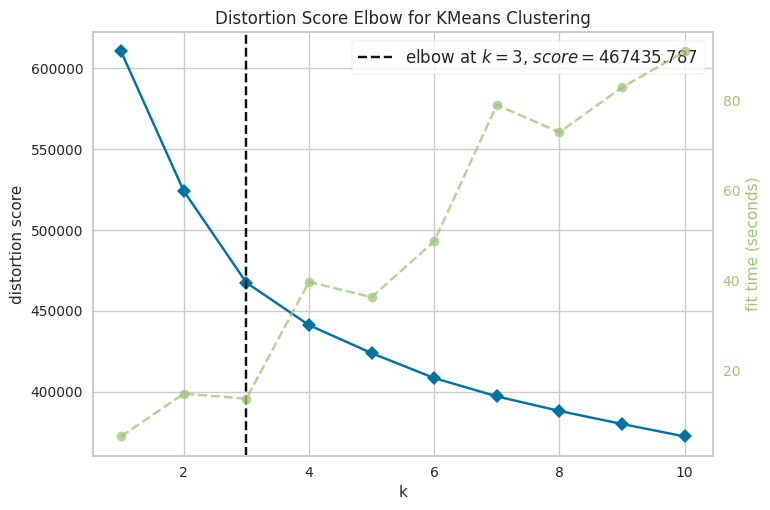

In [39]:
'''visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()'''


=== Average Silhouette Score for different number of clusters ===


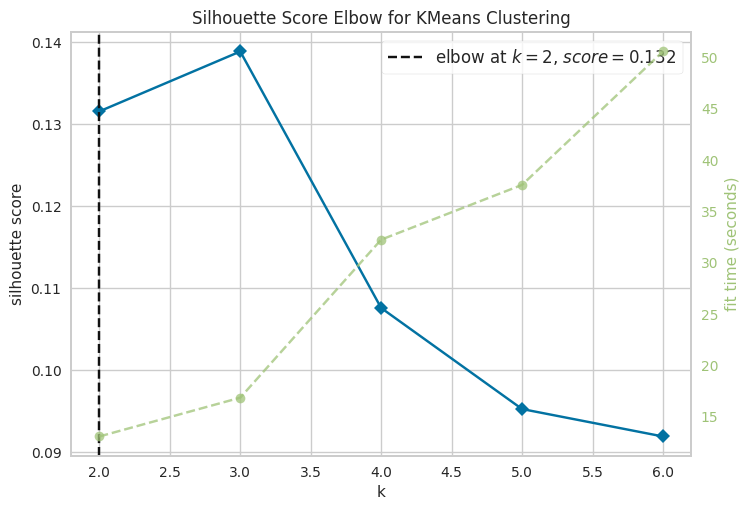



=== Silhouette plot for 2 Clusters ===


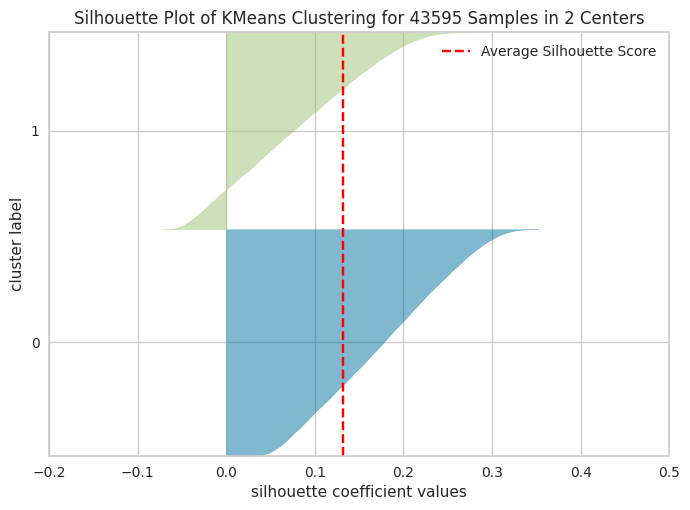



=== Silhouette plot for 3 Clusters ===


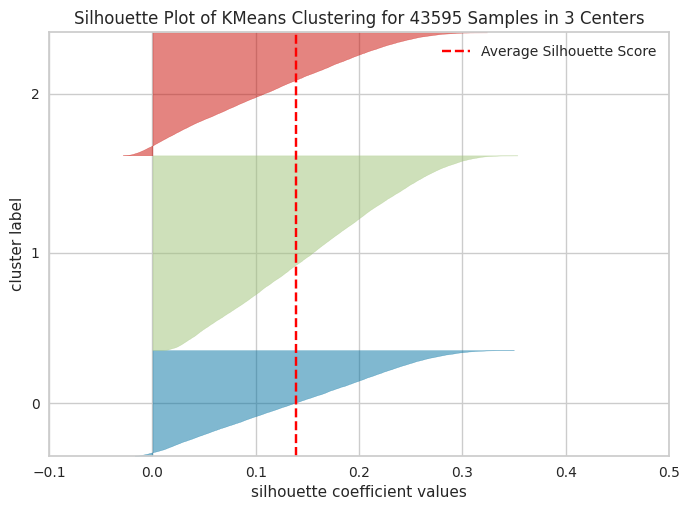



=== Silhouette plot for 4 Clusters ===


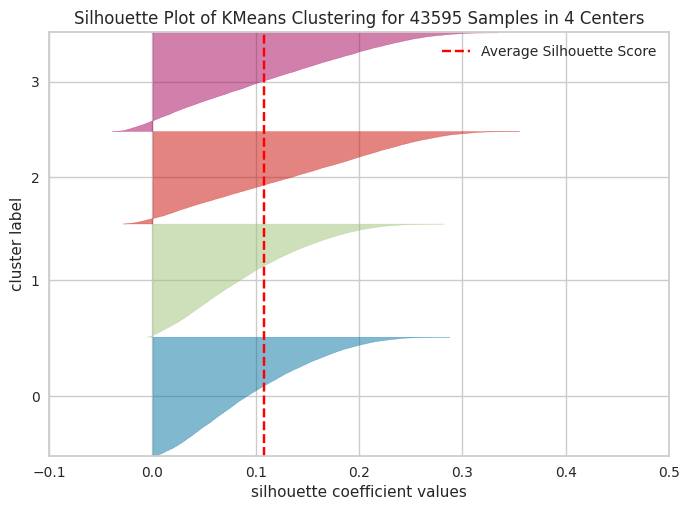



=== Silhouette plot for 5 Clusters ===


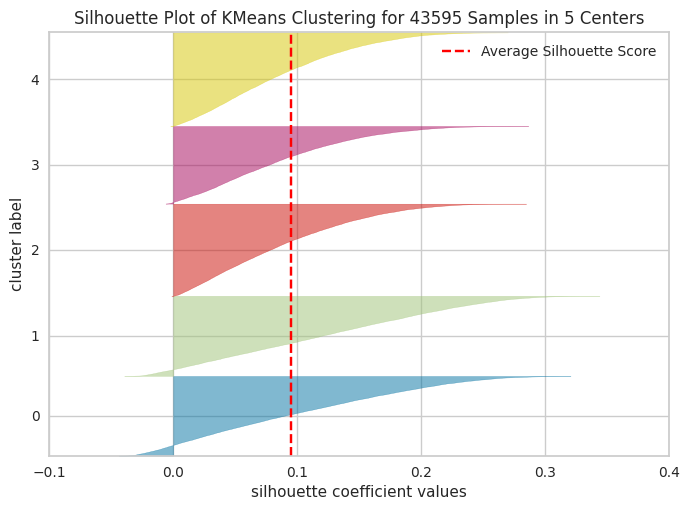



=== Silhouette plot for 6 Clusters ===


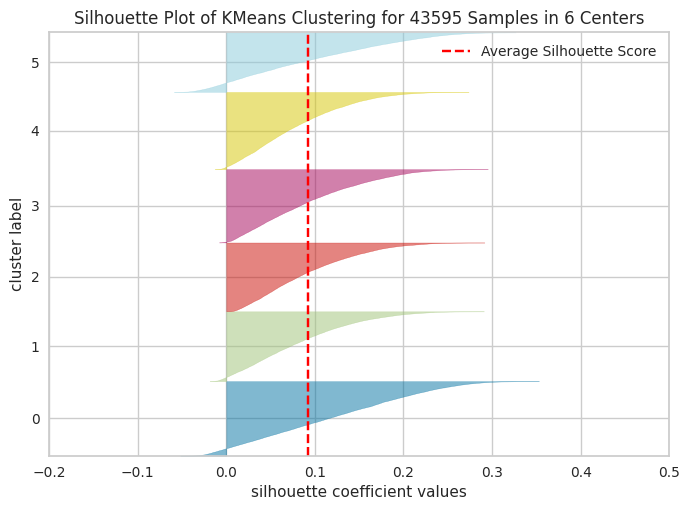

In [40]:
'''

n_cluster_start, n_cluster_stop = 2, 7

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")'''


Again, 3 clusters gives the highest Silhoutte coefficient.

In [41]:
new_game_w_clusters = game_data_reduced.copy()
last_pipe = last_cluster_pipe(clusters=3)
last_pipe.fit(new_game_w_clusters)
new_game_w_clusters['Clusters'] = last_pipe.predict(new_game_w_clusters)
new_game_w_clusters.head()

,fga_home,fg3a_home,fta_home,oreb_home,reb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,oreb_away,ast_away,tov_away,pts_away,Clusters
game_id,,,,,,,,,,,,,,,
28500005,92,3,18,16,44,25,5,91,78,2,11,21,17,100,1
28500006,88,2,41,20,48,17,2,104,80,0,11,19,18,108,1
28500010,88,1,49,17,57,23,0,118,88,5,13,27,20,116,1
28500011,82,2,38,10,34,30,9,108,89,0,17,23,19,112,1
28500008,91,4,52,18,47,17,7,105,88,3,13,26,22,119,1


* Cluster frequencies 
   Clusters
0      0.46
1      0.29
2      0.25 




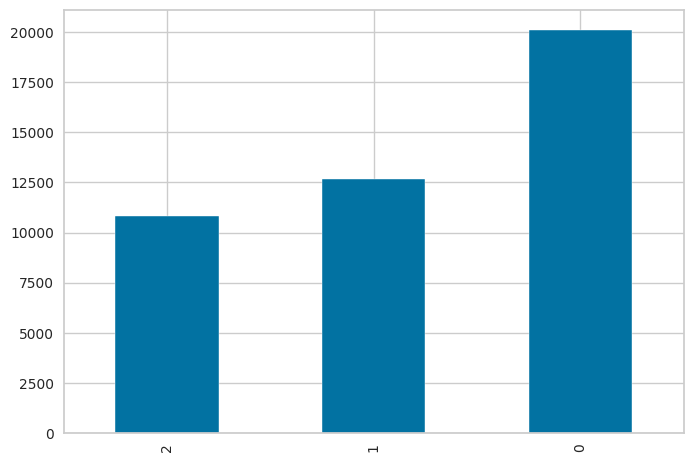

          Clusters    season
Clusters  1.000000  0.352382
season    0.352382  1.000000


In [46]:

value = new_game_w_clusters['Clusters'].value_counts(normalize=True).to_frame().round(2)
print(f"* Cluster frequencies \n{value} \n\n")
print("frequency computed")
new_game_w_clusters['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

game_seasons = get_df('game_pre_split', 'datasets/clean/csv').filter(['season'])

new_clusters_only = new_game_w_clusters.filter(['Clusters'])
new_season_clusters = new_clusters_only.join(game_seasons)

new_game_w_clusters = new_game_w_clusters.join(game_seasons)
print(new_season_clusters.corr())



Lets look at the distribution of seasons for each cluster like we did previously. We will compare it side by side with the old distribution. Note, the labels of the clusters may have changed so we have regruoped them by trying to match distributions.

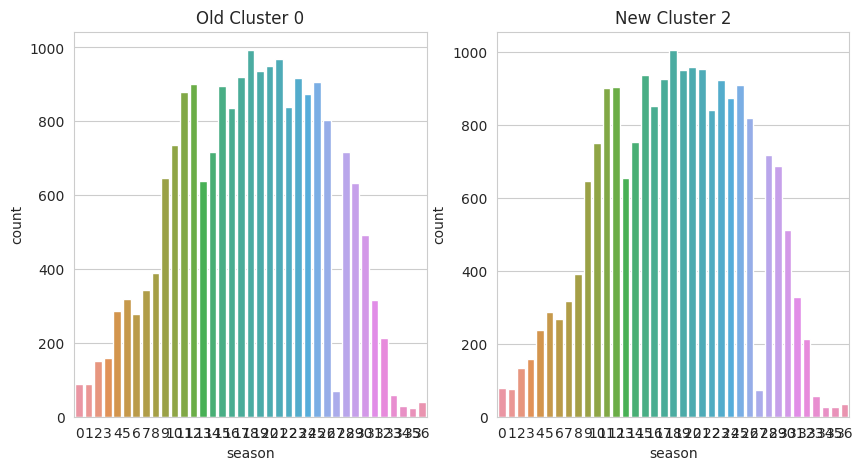

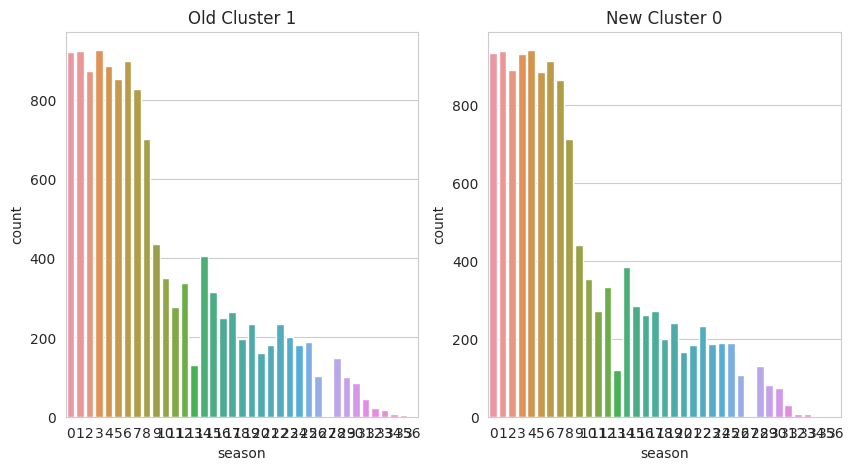

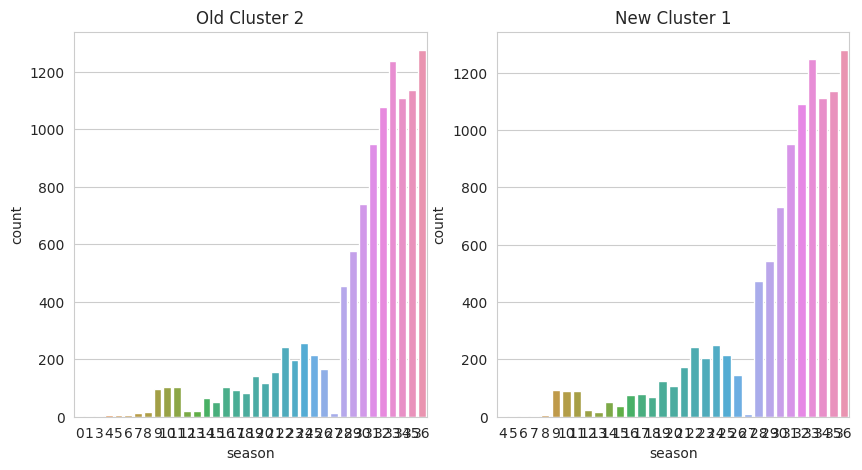

In [ ]:
pairs = [(0,2),(1,0),(2,1)]
for i,j in pairs:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    old_cluster = season_clusters.query(f'Clusters == {i}')
    new_cluster = new_season_clusters.query(f'Clusters == {j}')
    sns.countplot(data=old_cluster, x="season", ax=ax[0]).set_title(f"Old Cluster {i}")
    sns.countplot(data=new_cluster, x="season", ax=ax[1]).set_title(f"New Cluster {j}")
    plt.show()


Now we use a confusion matrix to compare the two different clusterings. Recall how the labelling has changed, so we will not see a diagonal matrix.

In [ ]:
from sklearn.metrics import confusion_matrix

new_predictions = new_game_w_clusters['Clusters']
old_predictions = game_w_clusters['Clusters']

print(confusion_matrix(new_predictions,old_predictions))

[[  864 11417   461]
 [  515   254  9906]
 [18680  1015   483]]


The clusters have moved a bit, but not too much (if you take the relabelling into account). Let's retrain the classification pipeline on this clustering.

In [ ]:
df = new_game_w_clusters.copy()
X_train, X_test, y_train, y_test = train_test_split(
                    df.drop(['Clusters'], axis=1),
                    df['Clusters'], test_size=0.2,
                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(34876, 12)
(8719, 12)


Just to remind you, these are the input for the pipeline.

In [ ]:
to_drop = [col for col in game_data.columns if col not in best_features]
print(to_drop)
new_assignments = { key: [val for val in value if val not in to_drop] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
print(new_assignments)

['fgm_home', 'fg3m_home', 'ftm_home', 'dreb_home', 'reb_home', 'stl_home', 'tov_home', 'pf_home', 'plus_minus_home', 'fgm_away', 'fg3m_away', 'ftm_away', 'fta_away', 'dreb_away', 'reb_away', 'stl_away', 'blk_away', 'tov_away', 'pf_away', 'home_wins', 'play_off']
{'yeo_johnson': ['blk_home', 'oreb_away', 'ast_home', 'pts_away', 'pts_home', 'oreb_home'], 'box_cox': ['ast_away', 'fta_home']}


In [ ]:
ada_params = {'n_estimators': 110, 'learning_rate': 1.133,
              'algorithm': 'SAMME.R'}

def last_clf_pipe():
    model = AdaBoostClassifier(random_state=42,**ada_params)
    pipe = Pipeline([('yeo_johnson',vt.YeoJohnsonTransformer(
                                    variables=new_assignments['yeo_johnson'])),
                                    ('box_cox',vt.BoxCoxTransformer(
                                    variables=new_assignments['box_cox'])),
                                    ('scaler', StandardScaler()),
                                    ('model', model)])
    return pipe

    
last_ada_pipe = last_clf_pipe()
last_ada_pipe.fit(X_train, y_train)

print("AdaBoost:")
predicted = last_ada_pipe.predict(X_test)
print(classification_report(y_test,predicted))

AdaBoost:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2556
           1       0.95      0.98      0.96      2170
           2       0.97      0.96      0.97      3993

    accuracy                           0.96      8719
   macro avg       0.96      0.96      0.96      8719
weighted avg       0.96      0.96      0.96      8719



This is performing even better than it did previously. We will look again at the importance of different features before employing the functions above which provided the profiles for the clusters.

Old importance levels
* These are the 12 most important features in descending order. The model was trained on them: 
['fga_home', 'fg3a_home', 'fg3a_away', 'fga_away', 'fta_home', 'oreb_away', 'oreb_home', 'ast_home', 'ast_away', 'pts_home', 'pts_away', 'blk_home']


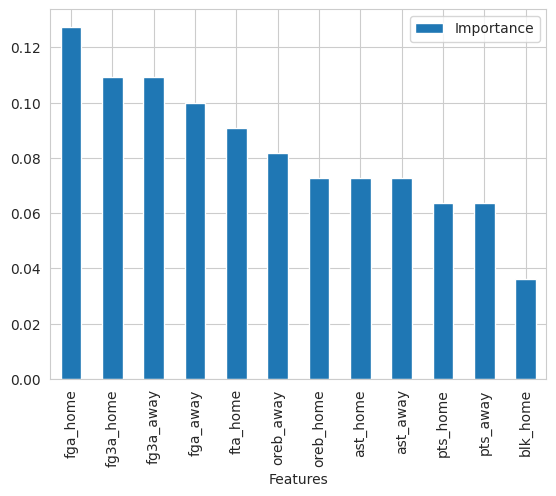

New importance levels
* These are the 12 most important features in descending order. The model was trained on them: 
['fg3a_away', 'fg3a_home', 'oreb_home', 'oreb_away', 'pts_away', 'fta_home', 'ast_home', 'fga_home', 'pts_home', 'fga_away', 'ast_away', 'blk_home']


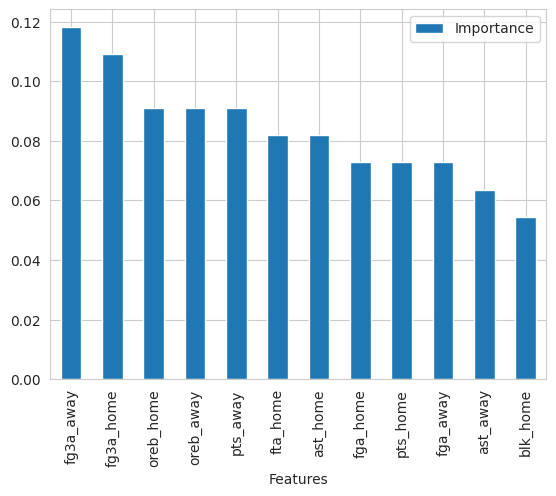

In [ ]:
print("Old importance levels")
tuned_model = tuned_ada_pipe['model']
feature_importance_tree_based_models(model=tuned_model,columns=best_features)
print("New importance levels")
ada_model = last_ada_pipe['model']
feature_importance_tree_based_models(model=ada_model, columns=best_features)

Now 3 point attempts of the away team are the most important feature.

In [ ]:
print(best_features)
new_game_w_clusters.columns

['fga_home', 'fg3a_home', 'fta_home', 'oreb_home', 'ast_home', 'blk_home', 'pts_home', 'fga_away', 'fg3a_away', 'oreb_away', 'ast_away', 'pts_away']


Index(['fga_home', 'fg3a_home', 'fta_home', 'oreb_home', 'ast_home',
       'blk_home', 'pts_home', 'fga_away', 'fg3a_away', 'oreb_away',
       'ast_away', 'pts_away', 'Clusters'],
      dtype='object')

In [ ]:
#cluster_distribution_per_variable(df, target):
df_cluster_profile = new_game_w_clusters.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)

pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df_cluster_profile, decimal_points=0)
clusters_profile

,fga_home,fg3a_home,fta_home,oreb_home,ast_home,blk_home,pts_home,fga_away,fg3a_away,oreb_away,ast_away,pts_away
Cluster,,,,,,,,,,,,
0,82.0 -- 93.0,5.0 -- 14.0,24.0 -- 35.0,11.0 -- 17.0,23.0 -- 30.0,4.0 -- 8.0,104.0 -- 118.0,83.0 -- 93.0,5.0 -- 14.0,11.0 -- 17.0,20.0 -- 27.0,98.0 -- 112.0
1,83.0 -- 92.0,24.0 -- 35.0,18.0 -- 28.0,8.0 -- 13.0,21.0 -- 28.0,3.0 -- 6.0,103.0 -- 118.0,82.0 -- 92.0,24.0 -- 35.0,7.0 -- 12.0,21.0 -- 27.0,101.0 -- 116.0
2,74.0 -- 83.0,11.0 -- 20.0,19.0 -- 30.0,9.0 -- 14.0,18.0 -- 24.0,3.0 -- 7.0,88.0 -- 102.0,74.0 -- 82.0,11.0 -- 19.0,8.0 -- 13.0,16.0 -- 23.0,85.0 -- 99.0


There are many features where two clusters have almost identical ranges. Let's look at the distribution of each feature colored by cluster.

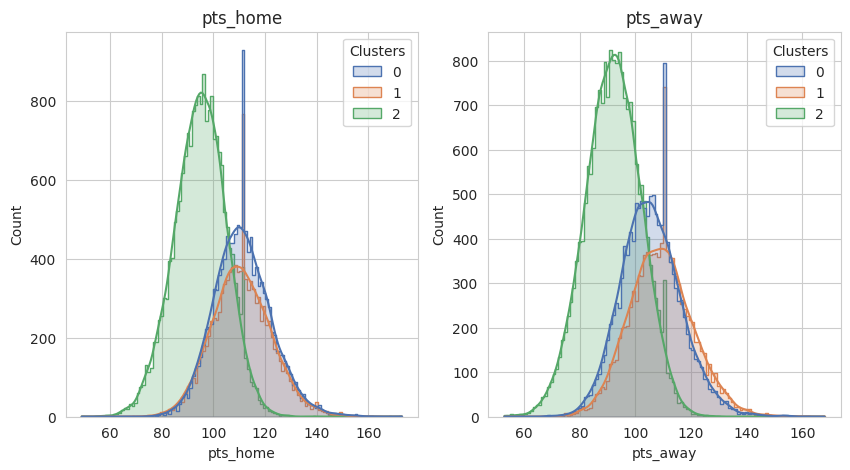

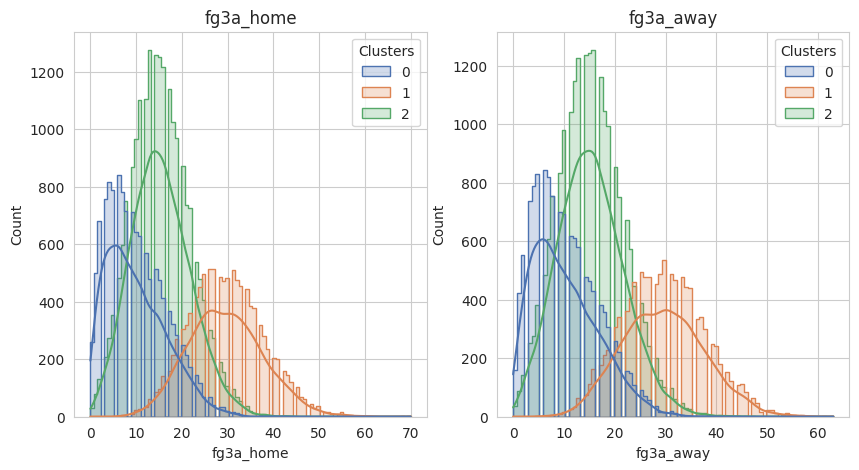

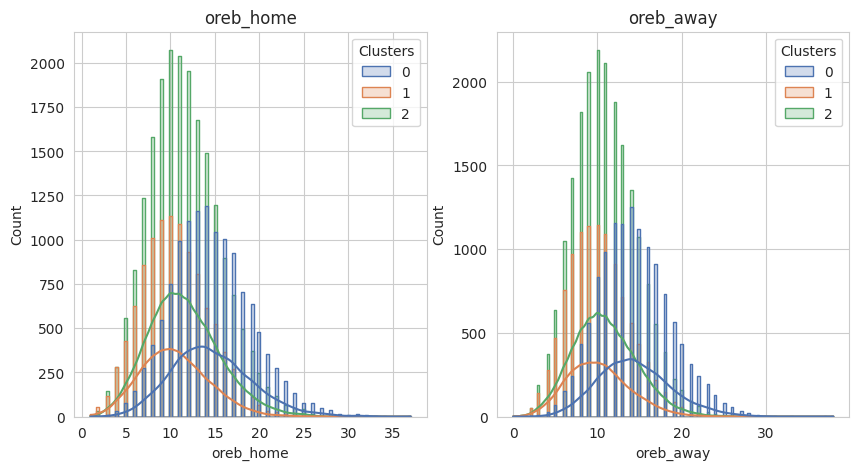

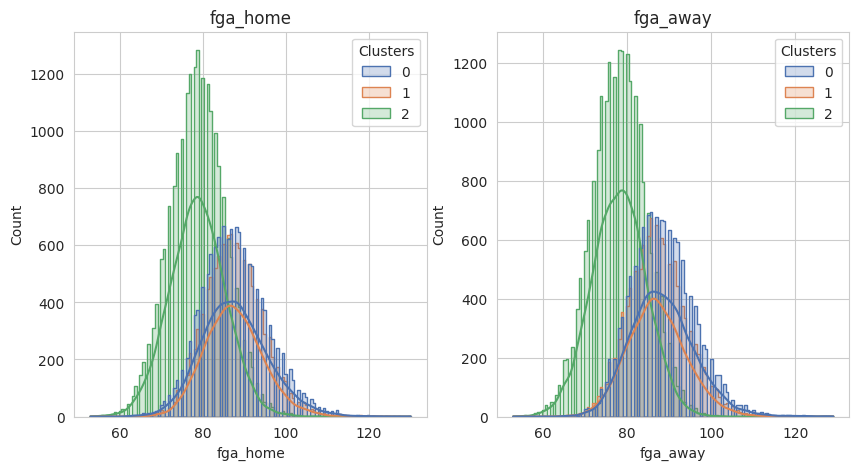

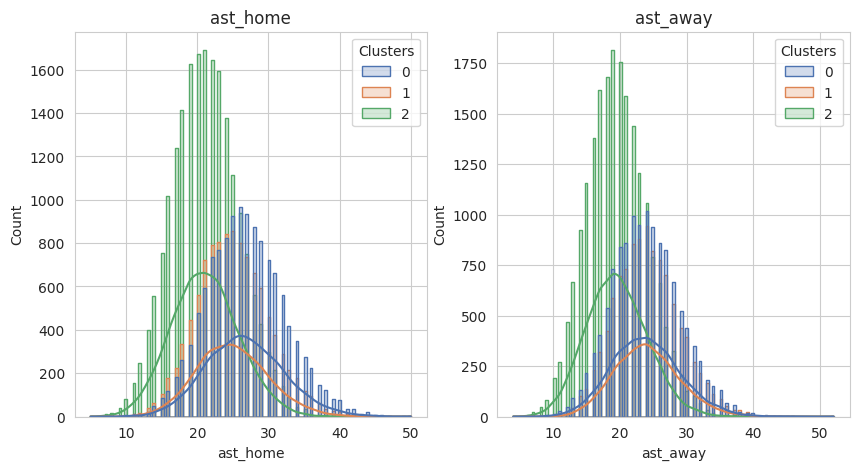

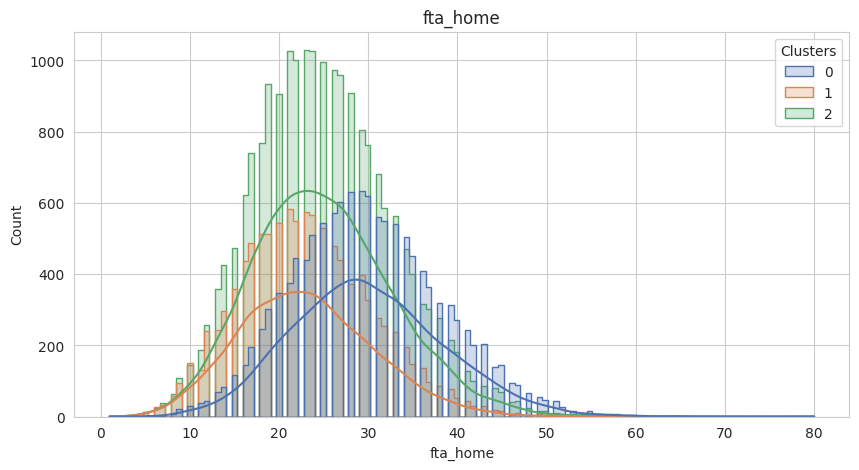

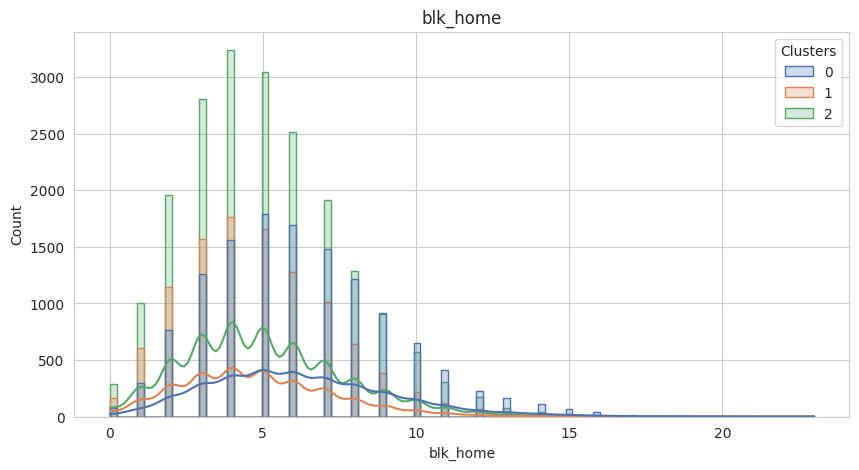

In [ ]:
feature_pairs = []
feature_stems = list({term.split('_')[0] for term in best_features})
for stem in feature_stems:
    home_stem = stem + '_home'
    away_stem = stem + '_away'
    if home_stem in best_features and away_stem in best_features:
        feature_pairs.append((home_stem, away_stem))
    elif home_stem in best_features:
        feature_pairs.append((home_stem, ''))
    elif away_stem in best_features:
        feature_pairs.append(('',away_stem))

for home, away in feature_pairs:
    if home and away:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        sns.histplot(data=df, x=home, kde=True, element="step", ax=axes[0],
                     hue='Clusters',palette='deep')
        sns.histplot(data=df, x=away, kde=True, element="step", ax=axes[1],
                     hue='Clusters', palette='deep')
        axes[0].set_title(f'{home}')
        axes[1].set_title(f'{away}')
        plt.show()
    elif home:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        sns.histplot(data=df, x=home, kde=True, element="step", ax=axes,
                     hue='Clusters', palette='deep')
        axes.set_title(f'{home}')
        plt.show()
    elif away:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        sns.histplot(data=df, x=away, kde=True, element="step", ax=axes,
                     hue='Clusters', palette='deep')
        axes.set_title(f'{away}')
        plt.show()

We see in these distributions the grouping mentioned above. Very frequently, a feature will have the same distributions over two clusters. It is a testiment to the model that it is still able to distinguish between these clusters so well.